In [1]:
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
import time

In [2]:
class PetModel(nn.Module):
    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )

        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.std = torch.tensor(params["std"]).view(1, 3, 1, 1)
        self.mean = torch.tensor(params["mean"]).view(1, 3, 1, 1)
        self.loss_fn = smp.losses.DiceLoss(
            smp.losses.BINARY_MODE, from_logits=True)

    def forward(self, image):
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask


In [3]:
model = torch.load("./model/model.pth", map_location=torch.device('cpu'))

In [4]:
# laod sample image

import cv2
import numpy as np
import matplotlib.pyplot as plt

image = cv2.imread("/home/venom/Pictures/sample.png")

In [5]:
# convert to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# reshape to closest multiple of 32 for the model
image = cv2.resize(image, (1024, 512))

In [6]:
cv2.imshow('image', image)
cv2.waitKey(0)

27

In [7]:
cv2.destroyAllWindows()

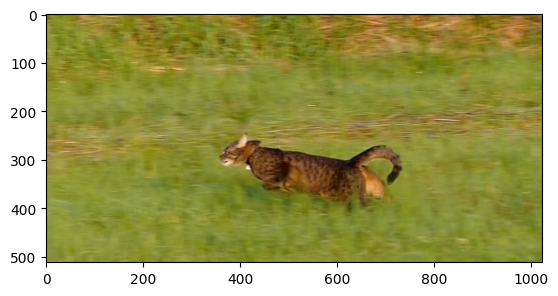

In [8]:
# plt image
plt.imshow(image)

In [9]:
# convert to tensor
image = torch.from_numpy(image).float().permute(2, 0, 1).unsqueeze(0)

In [10]:
# predict
mask = model(image)
# pass through sigmoid
mask = torch.sigmoid(mask)

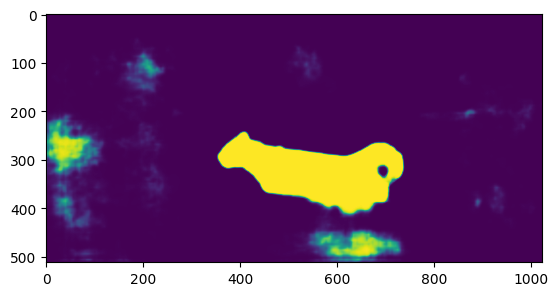

In [11]:
plt.imshow(mask.squeeze().detach().numpy())

In [24]:
# now do it for input video from file

cap = cv2.VideoCapture("./cat.mp4")

In [27]:
def preprocess_frame(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, (512, 256))
    frame_org = frame
    frame = torch.from_numpy(frame).float().permute(2, 0, 1).unsqueeze(0)
    return frame

def perform_inference(model, frame):
    inference_start_time = time.time()
    mask = model(frame)
    mask = torch.sigmoid(mask)
    mask = mask.squeeze().detach().numpy()
    inference_time = time.time() - inference_start_time
    return mask, inference_time

def postprocess_frame(mask):
    # Add any additional post-processing steps here if needed
    post_processing_time = 0  # Placeholder, as there are no explicit post-processing steps
    return post_processing_time

In [28]:
while True:
    # Record the start time before processing each frame
    start_time = time.time()
    ret, frame = cap.read()
    if ret:
        # Preprocessing
        preprocessing_start_time = time.time()
        frame = preprocess_frame(frame)
        preprocessing_time = time.time() - preprocessing_start_time
        # Inference
        mask, inference_time = perform_inference(model, frame)
        # Post-processing
        post_processing_time = postprocess_frame(mask)
        # Calculate FPS and frame time
        total_time = time.time() - start_time
        fps = 1.0 / total_time
        frame_time = total_time * 1000.0  # Convert to milliseconds
        # Print FPS and frame time
        print(f"FPS: {fps:.2f}, Frame Time: {frame_time:.2f} ms, "
              f"Preprocessing Time: {preprocessing_time:.2f} s, "
              f"Inference Time: {inference_time:.2f} s, "
              f"Post-processing Time: {post_processing_time:.2f} s", end="\r")
        # Display the processed frame (mask) if you need to
        cv2.imshow('mask', mask)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            cv2.destroyAllWindows()
            break
    else:
        break